In [1]:
push!(LOAD_PATH, "../../src")
using FCA
using Colors, Images, FileIO, Plots, Statistics, LinearAlgebra, Random

┌ Info: Recompiling stale cache file /Users/haowurm/.julia/compiled/v1.0/FCA.ji for FCA [top-level]
└ @ Base loading.jl:1190


In [2]:
function extractpatches(image,patchsize,stride=1)
    return Matrix{eltype(image)}[image[i:i+patchsize-1,j:j+patchsize-1]
                    for i in 1:stride:size(image,1)-(patchsize-1),
                        j in 1:stride:size(image,2)-(patchsize-1)]
end

extractpatches (generic function with 2 methods)

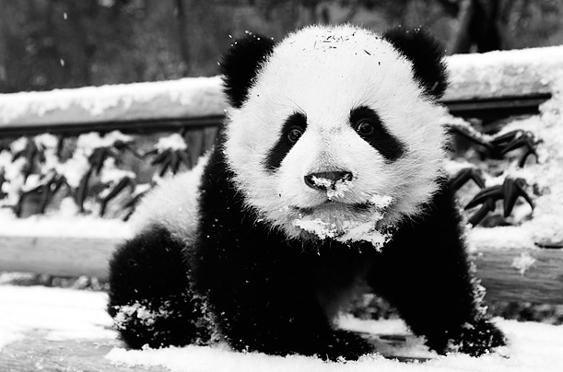

In [3]:
image = "../images/panda.jpg"
img = Float64.(Gray.(load(image)))
Gray.(img)

In [4]:
include("patch_displaying_utils.jl")
patches = extractpatches(img,8)
patchmat = hcat(vec.(patches)...);

size(patchmat) = (64, 202940)


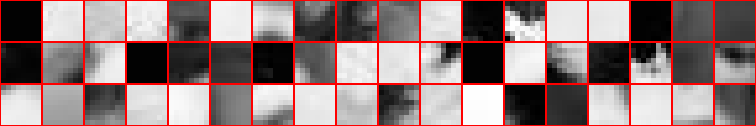

In [5]:
@show size(patchmat)
viewpatches(rand(patches,(3,18)))

In [6]:
batch_size = 50000
npatches = size(patchmat,2) 
rand_idx = randperm(npatches)[1:batch_size]
rand_patchmat = patchmat[:,rand_idx];

## ICA patches

We regard these small patches are linear combinations of $64$ $\sf ICA$ components. Assume that the coefficient of a certain ICA component between different patches are i.i.d random variables. Further assume that the coefficents for different ICA components are independent, this patches can be regarded as generated following
a ICA model:

$$
    patchmat = W_{ica} X_{ica}
$$

where columns of $W_{ica}$ is the vectorization of ICA components, $X_{ica}$, which represents the coefficients, is modeled as i.i.d samples of independent random variables.

In [7]:
Zica = [vec(rand_patchmat[i,:]) for i = 1: size(rand_patchmat, 1)];
@time Wica, Xica = icf(Zica; opt = "orth")

InterruptException: InterruptException:

## FCA patches

We can regard those small patches are linear combinations of $63$ $\sf FCA$ components (the uniform one is removed as we assume the centered matrix). 
In contrast to $\sf ICA$ case, we do not make assumption on the coefficients. 
Instead, we regard $\sf FCA$ components are freely independent matrices.

Reshaping the columns of $patchmat$ back to patches, we get an array $patcharr$ of $8 \times 8$ matrices. By above discussion, we have the decomposition

$$
    patcharr = W_{fca} X_{fca},
$$

where the free components in $X_{fca}$ stand for the $\sf FCA$ components and $W_{fca}$ denotes corresponding  coefficients.

In [43]:
patcharr = [reshape(rand_patchmat[:, i], (8,8)) for i = 1: size(rand_patchmat, 2)];

Note that if we set `batch_size` to be $50000$, $W_{fca}$ will be a $50000 \times 64$ matrix. The whitening process in FCF, whien being applied to `patcharr`, involves the eigenvalue decomposition of a $50000 \times 50000$ matrix. (We will take first $64$ eigenvalues and eigenvectors, as the rest eigenvalues are $0$ and irrelavant to the data.) This is time comsuming and unnecessary, a SVD for matrices is desired here.

Note that the covariance of a pair of centered matrices $X_1, X_2 \in \mathbb R^{N \times M}$ is

$$
    \frac{1}{N} \mathrm{Tr}(X_1 \cdot X_2^T),
$$

which is equivalent to

$$
    \frac{1}{N} vec(X_1)^T \cdot vec(X_2).
$$

Therefore, 
The non-zero eigenvalues of 

$$
    \left[\frac 1 N Tr.(patcharr[i]*patcharr[j]') \right]_{i,j = 1}^{50000}
$$

are $\frac1N \sigma_i^2$ where $\sigma_i$ denotes the non-zero singualr value of `patchmat`. 
The corresponding eigenvectors are exactly the right singular vectors of `patchmat`. 


Let us verify this in the following block.

In [104]:
# sample an array of 64 element
testarr = patcharr[1:64];

# results from free_whitening
Y, U, Σ = free_whiten(testarr; mat = "rec");

# results from applying SVD to the patchmat
testmat = rand_patchmat[:, 1:64]

# center the columns of testmat
testmat = testmat - ones(size(testmat, 1))* mean(testmat; dims = 1)

# SVD
Us, Σs, = svd(testmat');

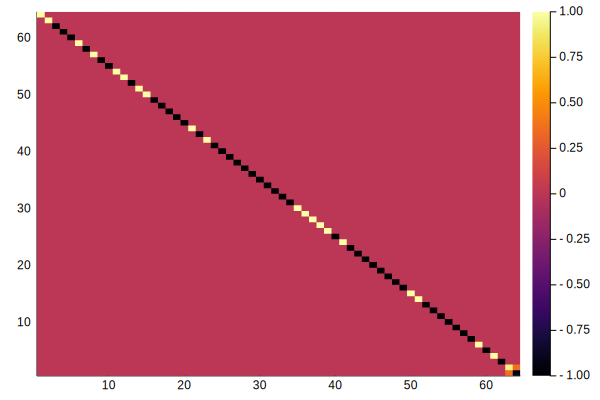

In [105]:
heatmap(U'*Us)

In [7]:
## we now apply SVD to the 50000 patches
rand_patchmat = rand_patchmat - ones(size(rand_patchmat, 1))* mean(rand_patchmat; dims = 1);
U, Σ,  = svd(rand_patchmat');

## take first 63 singular value and singular vectors
U = U[:, 1: 63]
Σ = Σ[:, 1: 63]

BoundsError: BoundsError: attempt to access 64-element Array{Float64,1} at index [Base.Slice(Base.OneTo(64)), 1:63]

In [8]:
## take first 63 singular value and singular vectors
U = U[:, 1: 63]
Σ = Σ[1: 63]
Y = pinv(Diagonal(Σ))*U'*[(reshape(rand_patchmat[:, i], (8,8)) 
        - mean(rand_patchmat[:, i]) * ones(8, 8)) for i = 1: size(rand_patchmat, 2)];

┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/haowurm/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47
┌ Warning: Linesearch failed, using alpha = 0.0 and exiting optimization.
│ The linesearch exited with message:
│ Linesearch failed to converge, reached maximum iterations 50.
└ @ Optim /Users/haowurm/.julia/packages/Optim/ULNLZ/src/utilities/perform_linesearch.jl:47


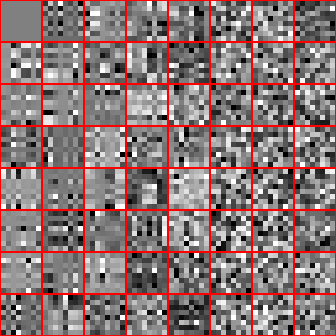

In [37]:
_, Xfca = freecf(Y; mat = "rec", opt = "sphe", obj = "kurt");
patchfca = [normpatch(Xfca[i]) for i in 1:63]
prepend!(patchfca, [0.5*ones(8,8)])
viewpatches(reshape(patchfca,(8,8)))